In [ ]:
from scipy import io
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import csv
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shared_folder_path = '/content/drive/MyDrive/CCS3/Extracted Data/PreprocessedData/Commercial Movie'
print(os.listdir(shared_folder_path))

['extr_fill_data_Test31.mat', 'extr_fill_data_Test25.mat', 'extr_fill_data_Test19.mat', 'extr_fill_data_Test18.mat', 'extr_fill_data_Test24.mat', 'extr_fill_data_Test30.mat', 'extr_fill_data_Test26.mat', 'extr_fill_data_Test32.mat', 'extr_fill_data_Test33.mat', 'extr_fill_data_Test27.mat', 'extr_fill_data_Test23.mat', 'extr_fill_data_Test37.mat', 'extr_fill_data_Test36.mat', 'extr_fill_data_Test22.mat', 'extr_fill_data_Test08.mat', 'extr_fill_data_Test34.mat', 'extr_fill_data_Test20.mat', 'extr_fill_data_Test21.mat', 'extr_fill_data_Test35.mat', 'extr_fill_data_Test09.mat', 'extr_fill_data_Test127.mat', 'extr_fill_data_Test52.mat', 'extr_fill_data_Test46.mat', 'extr_fill_data_Test47.mat', 'extr_fill_data_Test53.mat', 'extr_fill_data_Test126.mat', 'extr_fill_data_Test130.mat', 'extr_fill_data_Test118.mat', 'extr_fill_data_Test45.mat', 'extr_fill_data_Test51.mat', 'extr_fill_data_Test79.mat', 'extr_fill_data_Test78.mat', 'extr_fill_data_Test50.mat', 'extr_fill_data_Test44.mat', 'extr_fil

# Data preprocessing

In [ ]:
table1 = io.loadmat(shared_folder_path + "/extr_fill_data_Test01.mat")

In [ ]:
#df1 = pd.DataFrame(table1)
p = table1["GJP_student"]
x = table1["GJX_student"]
y = table1["GJY_student"]

In [ ]:

df = pd.DataFrame({
    "p": p.ravel(),
    "x": x.ravel(),
    "y": y.ravel()
})
print(df)

              p           x           y
0        1597.0  562.496277  371.598145
1        1599.0  562.596313  371.398163
2        1601.0  562.696350  371.198181
3        1603.0  562.796387  370.998199
4        1605.0  562.896423  370.798218
...         ...         ...         ...
1289995  2709.0  596.700012  378.000000
1289996  2708.0  596.500000  378.000000
1289997  2708.0  596.500000  378.000000
1289998  2708.0  596.599976  377.899994
1289999  2709.0  596.799988  377.799988

[1290000 rows x 3 columns]


In [ ]:
# checking the shapes of the original data
print(f"Original shape of p: {p.shape}")
print(f"Original shape of x: {x.shape}")
print(f"Original shape of y: {y.shape}")

Original shape of p: (1290000, 1)
Original shape of x: (1290000, 1)
Original shape of y: (1290000, 1)


In [ ]:
# assuming data is 1D (1290000,)
# downsampling by taking every 100th element --> 10Hz instead of 1000Hz
def downsample(original_rate, new_rate, data):

    factor = original_rate//new_rate # // --> ti get integer for slicing the dataframe
    downsampled_df = df.iloc[::factor].reset_index(drop = True)

    return downsampled_df

df_10Hz = downsample(1000, 10, df)
#df_20Hz = downsample(1000, 20, df)

In [ ]:
eb_list = [340, 1530, 2300, 3600, 4790, 5290, 7000, 7540, 8380, 8610, 8800, 9290, 9650, 10260, 10600, 11130, 11810, 12450, 12870]

def event_boundaries(original_rate, new_rate, eb_list):
    factor = original_rate//new_rate
    event_boundaries = list(event * (100 / factor)  for event in eb_list)
    return event_boundaries

eb_10Hz = event_boundaries(1000, 10, eb_list)

In [ ]:
def calculate_speed(x_series, y_series):
    '''Todo: check correctness!!!'''
    x_series = np.array(x_series)
    y_series = np.array(y_series)

    previous_x = np.roll(x_series, 1)
    previous_y = np.roll(y_series, 1)

    delta_x = x_series - previous_x
    delta_y = y_series - previous_y

    delta_x[0] = 0
    delta_y[0] = 0

    speed = np.sqrt(delta_x**2 + delta_y**2)

    return speed

s = calculate_speed(x, y)
s_10Hz = calculate_speed(df_10Hz["x"], df_10Hz["y"])

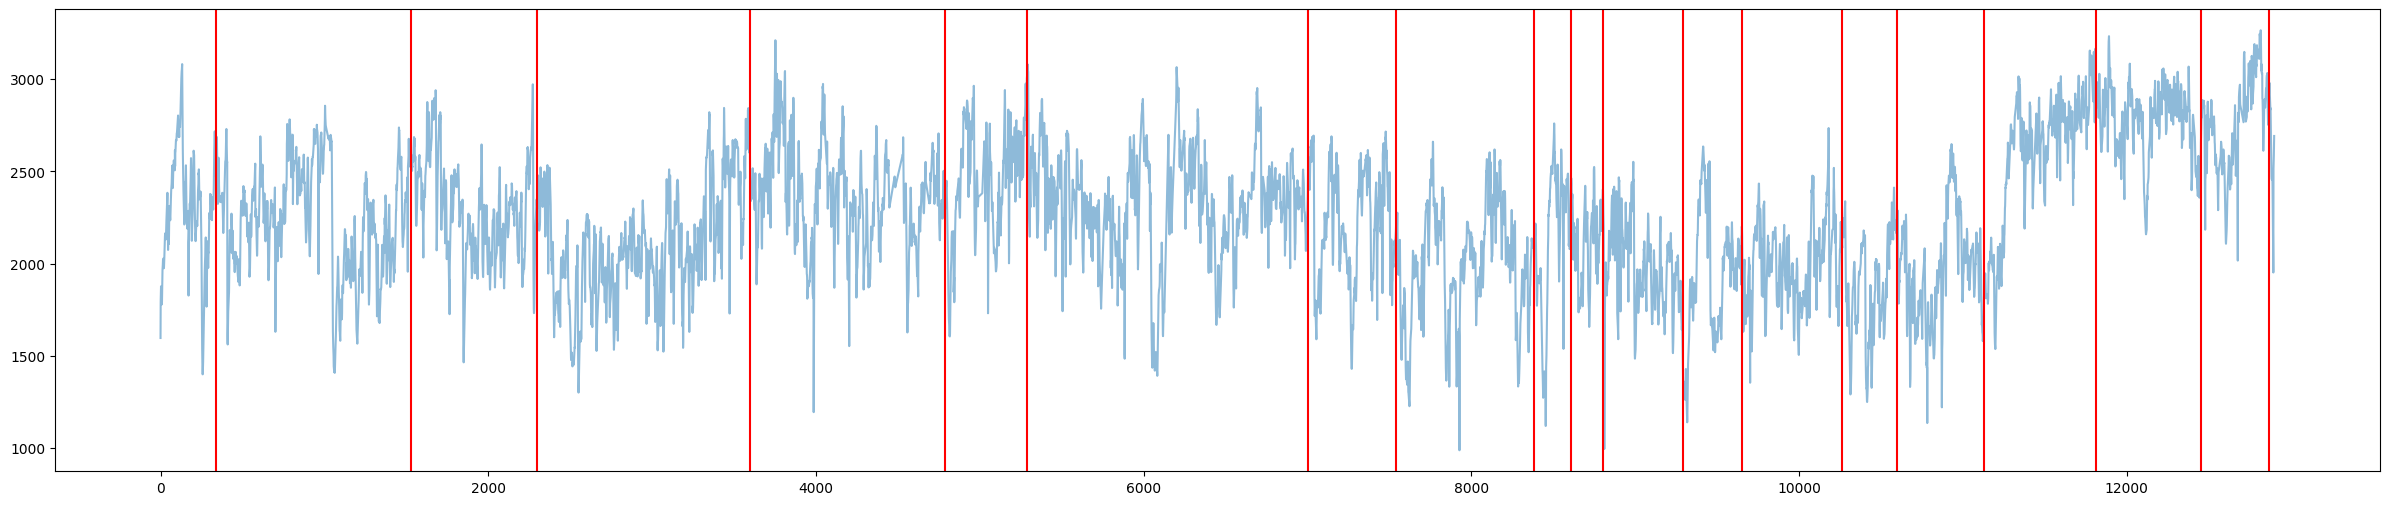

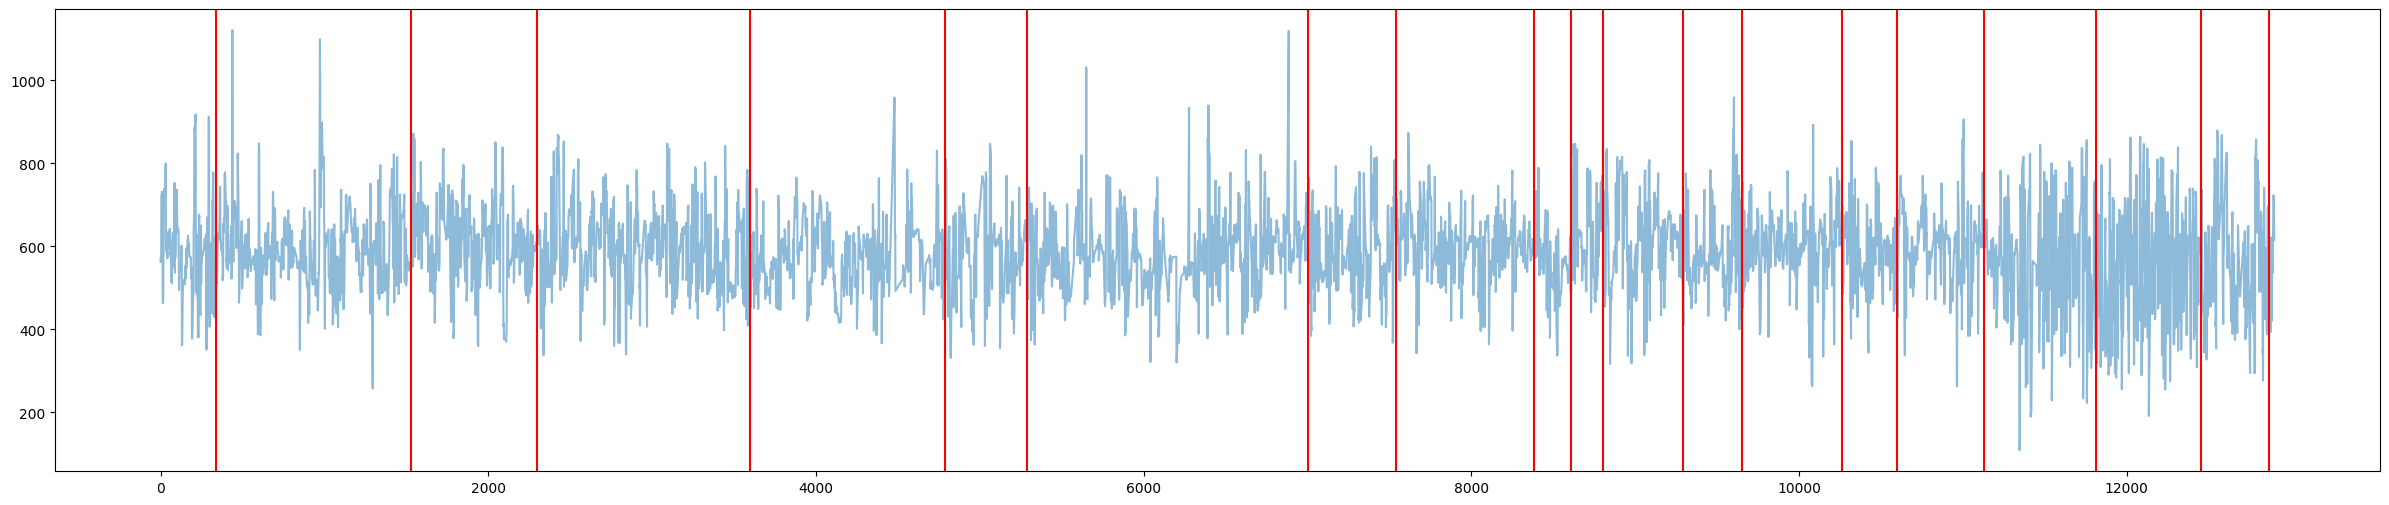

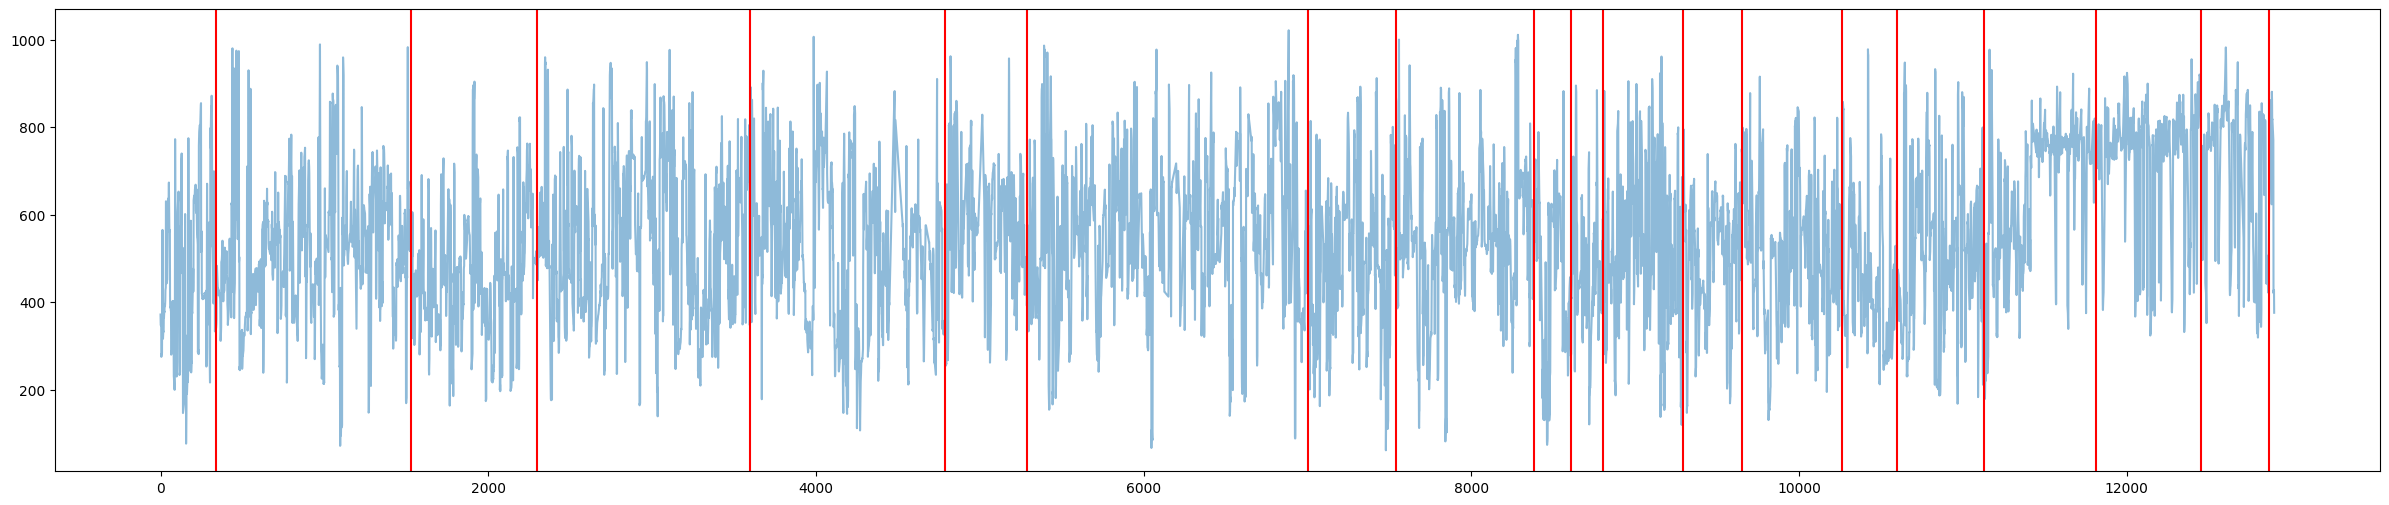

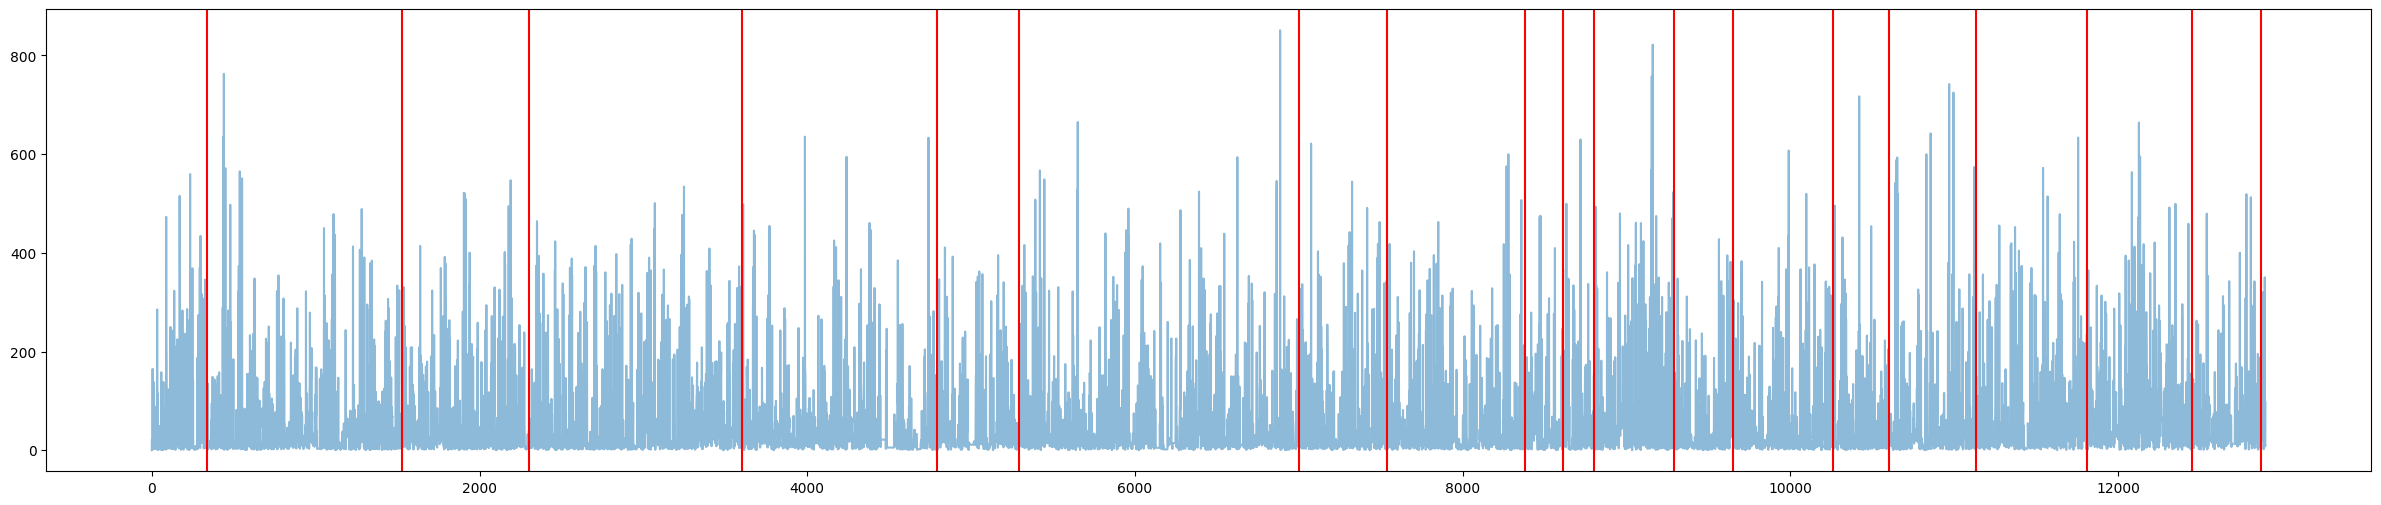

In [ ]:
def plot_series(series, eb_list):
    figure = plt.figure(figsize=(30,6))
    plt.plot(np.arange(len(series)), series, alpha = 0.5)
    for event_boundary in eb_list:
        plt.axvline(event_boundary, color = "r")

plot_series(df_10Hz["p"], eb_10Hz)
plot_series(df_10Hz["x"], eb_10Hz)
plot_series(df_10Hz["y"], eb_10Hz)
plot_series(s_10Hz, eb_10Hz)

In [ ]:
speed = s_10Hz
pupil_size = df_10Hz["p"]
boundaries = eb_10Hz

x_ps = np.vstack((speed, pupil_size)).T

In [ ]:
x_ps.shape

(12900, 2)

340.0
2605.0
(18, 100)


Text(0.5, 1.0, 'Pupil size around the event boundary averaged over all events in 100 steps')

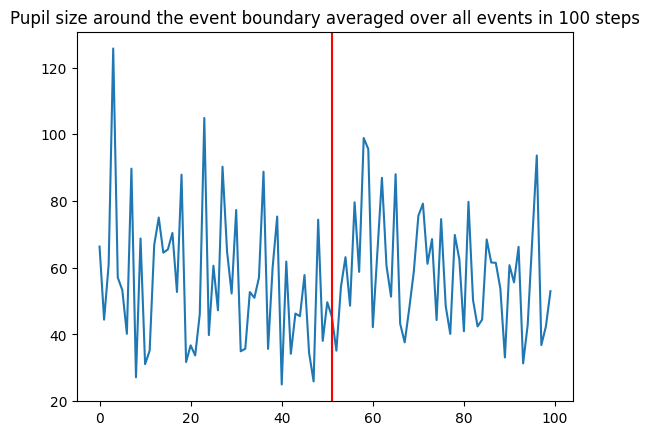

In [ ]:
#data around event boundaries
#for now use only even numbers
number_time_points = 100

print(boundaries[0])
print(pupil_size[int(boundaries[0])])

time_points_around_events = np.zeros(shape = (len(boundaries) - 1, number_time_points))
for j, event_boundary in enumerate(boundaries[:-1]):

    for i in range(number_time_points):
        #print(j, i)
        data_around_event = speed[int(event_boundary + i - number_time_points/2)]
        time_points_around_events[j, i]= data_around_event


print(np.shape(time_points_around_events))
avg_around_events = np.mean(time_points_around_events, axis = 0)
std_around_events = np.std(time_points_around_events, axis = 0)


plt.plot(avg_around_events)
#plt.plot(avg_around_events - std_around_events)
#plt.plot(avg_around_events + std_around_events)

plt.axvline(number_time_points/2 + 1, c = "r")
plt.title(f"Pupil size around the event boundary averaged over all events in {number_time_points} steps")

In [ ]:
def sample_events_no_events(
    data,
    event_boundaries,
    num_samples=100
):
    """
    Continuously samples 100-point windows from 'data' until it has
    collected exactly 'num_samples' windows with 0 boundaries (no_events)
    and 'num_samples' windows with exactly 1 boundary (events).

    Parameters
    ----------
    data : np.ndarray
        Shape (N, 2). data[:,0] = speed, data[:,1] = pupil.
    event_boundaries : list or np.ndarray of int
        Indices of event boundaries.
    num_samples : int, optional
        How many samples we want in each list (no_events and events).

    Returns
    -------
    no_events : list of tuples
        Each element is (speed_100, pupil_100), with speed_100.shape = (100,)
        and pupil_100.shape = (100,).
    events : list of tuples
        Same format, but each has exactly 1 event boundary in the slot.
    """
    data_length = data.shape[0]
    if data_length < 100:
        raise ValueError("Data must have at least 100 rows to extract 100-point windows.")

    # Lists to store results
    no_events = []
    events_ = []

    # Convert event_boundaries to a set for faster membership checks, if large
    event_boundaries_set = set(event_boundaries)

    # We'll sample until we have enough in both lists
    # or we reach some iteration limit (to avoid infinite loops).
    max_iterations = 100000  # Arbitrary large limit
    iteration_count = 0

    while (len(no_events) < num_samples or len(events_) < num_samples) and (iteration_count < max_iterations):
        iteration_count += 1

        # 1) Pick a random start index
        start_idx = random.randint(0, data_length - 100)
        end_idx = start_idx + 100

        # 2) Count how many boundaries in [start_idx, end_idx)
        #    We'll just iterate over the set:
        boundaries_in_window = 0
        for b in event_boundaries_set:
            if start_idx <= b < end_idx:
                boundaries_in_window += 1
            if boundaries_in_window > 1:
                break  # no need to count further if it's >1

        # 3) If exactly 0 or exactly 1, store them
        if boundaries_in_window == 0 and len(no_events) < num_samples:
            # Slice out the speed and pupil
            speed_100 = data[start_idx:end_idx, 0]
            pupil_100 = data[start_idx:end_idx, 1]
            no_events.append((speed_100, pupil_100))
        elif boundaries_in_window == 1 and len(events_) < num_samples:
            speed_100 = data[start_idx:end_idx, 0]
            pupil_100 = data[start_idx:end_idx, 1]
            events_.append((speed_100, pupil_100))
        # else ignore if boundaries_in_window >= 2

    return no_events, events_

In [ ]:
# Example usage
time_series = x_ps  # Example time series with 2 channels
event_boundaries = boundaries  # Example boundaries
l = 100  # Length of each subsection
n_samples = 100  # Total number of subsections (must be even)


no_events= []
events = []
sections_with, sections_without = sample_events_no_events(time_series, event_boundaries)

print(sections_without[0][0])

[ 83.08119048  53.87633441 160.15781704  22.32713365  16.97556231
   1.4422239    5.84123609  99.9928157   20.51423244  19.2517163
  19.2517163   65.05352457 100.19844419 100.19844419 100.19844419
 100.19844419  77.19609867 512.49837978  13.53738536  17.37624419
  17.37624419  17.37624419  17.37624419   3.7304013    6.33878914
  14.56021978 103.10595609  20.36130736  20.36130736 252.81372122
 291.91485613  23.14617458  26.45921984  26.45921984  40.36653935
 152.50476697 296.09743251  10.85770682  73.67672885 342.13263329
   4.24504048  66.28379605  71.43676543  71.43676543  71.43676543
  50.23509379  79.46552362  88.62481718  88.62481718  88.62481718
  15.44724144  15.8262474   28.17959845  28.17959845  63.21890922
 134.91644521 134.91644521  48.55188964   4.30116263   6.88841996
 195.08226718   1.06301343  10.90046666   3.26955169  21.88378214
 188.56108593 105.00371673  21.5538663   21.5538663   21.5538663
  10.31238691   7.46728608  10.75196579  69.35760682  69.35760682
  69.3576068

In [ ]:
def merge_datasets(no_events, events, shuffle_data=True):
    """
    Merges two lists (no_events, events) into a single preprocessed_data list.
    Each element in preprocessed_data is (speed_100, pupil_100, label).

    Parameters
    ----------
    no_events : list
        Each element is a tuple (speed_100, pupil_100),
        with speed_100.shape = (100,) and pupil_100.shape = (100,).

    events : list
        Same format, but each belongs to exactly 1 boundary window.

    shuffle_data : bool
        If True, shuffle the merged dataset.

    Returns
    -------
    preprocessed_data : list
        A list of tuples (speed_100, pupil_100, label),
        where label=0 for no_events, and label=1 for events.
    """
    preprocessed_data = []

    # Label 0 for no_events
    for (speed_100, pupil_100) in no_events:
        preprocessed_data.append((speed_100, pupil_100, 0))

    # Label 1 for events
    for (speed_100, pupil_100) in events:
        preprocessed_data.append((speed_100, pupil_100, 1))

    # Optionally shuffle
    if shuffle_data:
        random.shuffle(preprocessed_data)

    return preprocessed_data

In [ ]:
merged = merge_datasets(sections_with, sections_without)
print(merged[0][2])


0


merged shape: [samlpes: 200, speed vs pupil vs label: 3, timepoint: 100/ label: 1]    

In [ ]:
# Applying to all participants
def get_data(table1):
    p = table1["GJP_student"]
    x = table1["GJX_student"]
    y = table1["GJY_student"]

    df = pd.DataFrame({
        "p": p.ravel(),
        "x": x.ravel(),
        "y": y.ravel()
    })

    df_10Hz = downsample(1000, 10, df)

    s_10Hz = calculate_speed(df_10Hz["x"], df_10Hz["y"])

    speed = s_10Hz
    pupil_size = df_10Hz["p"]
    boundaries = eb_10Hz

    x_ps = np.vstack((speed, pupil_size)).T

    sections_with, sections_without = sample_events_no_events(data = x_ps, event_boundaries = boundaries)

    datasets_merged = merge_datasets(sections_with, sections_without)
    return datasets_merged

In [ ]:
# Define input folder and output file
input_folder = shared_folder_path  # Adjust the path to your folder
output_file = 'output_file.csv'

df_output = pd.DataFrame(columns = ["participant", "data"])

# Open the output CSV file for writing
with open(output_file, mode='w', newline='') as output_csv:
    writer = csv.writer(output_csv)

    # Iterate over files in the input folder
    for filename in os.listdir(input_folder):
        input_file_path = os.path.join(input_folder, filename)

        # Check if the file is a valid file (not a directory)
        if os.path.isfile(input_file_path):
            table = io.loadmat(input_file_path)
            data = get_data(table)
            new_row = {'participant': filename, 'data': data}
            df_output.loc[len(df_output)] = new_row

print(f"Data from input files has been written to {output_file}.")


In [ ]:
len(df_output["data"])
# data shape: [participants: 105, samlpes: 200, speed vs pupil vs label: 3, timepoint: 100/ label: 1]

105

In [ ]:
df_output['data'][0][0]

(array([ 15.62851093,  12.81597561,  61.24915485, 146.81461397,
         23.40873211,  21.04591753,   4.96789547, 326.69147447,
         19.72308354, 221.94716207,  41.60696898,  16.84429857,
         20.12585417,  56.51990222,  66.56129368, 191.67788545,
        191.67788545, 126.97955461,   3.86262768,   4.16769981,
        336.54894032,  24.01541716,   4.04601765,   9.79436982,
        243.56210707, 179.13294468,   6.16604561,  14.45164541,
         16.12452912,  10.77867236,   3.39709061,  11.27874707,
        167.52313273,  13.7905545 ,  87.89769345,   4.24381558,
        214.01953159,  13.06139887,  13.81305522, 125.49716911,
          7.49463032, 219.09513365,   9.06862953,   3.20154401,
        187.63160528,  22.00363651,  99.7969873 ,   7.76464539,
         84.53548406,  14.08582649, 116.64992265,  96.41845406,
        191.61923177, 191.61923177,  21.59073709, 167.23630881,
        167.23630881, 137.40997618, 106.59123812,  11.85625015,
         35.10697936,   2.37698185,   4.

In [ ]:
# Saving to external csv file
#df_output.to_csv('output_df.csv', index=False)

# RNN Model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
class TwoChannelBoundaryRNN(nn.Module):
    def __init__(self, input_size, hidden_size = 64, num_layers = 2):
        super(TwoChannelBoundaryRNN, self).__init__()

        # RNN for channel 1
        self.rnn1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # RNN for channel 2
        self.rnn2 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer for combined output
        self.fc = nn.Linear(hidden_size * 2, 1)  # Combine both channels' outputs
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        # Process each channel
        h1, _ = self.rnn1(x1)  # Channel 1
        h2, _ = self.rnn2(x2)  # Channel 2

        # Get the last time step's output for both channels
        h1_last = h1[:, -1, :]
        h2_last = h2[:, -1, :]

        # Concatenate the outputs from both channels
        combined = torch.cat((h1_last, h2_last), dim=1)

        # Pass through the fully connected layer
        out = self.fc(combined)
        out = self.sigmoid(out)  # Sigmoid activation for binary classification

        return out

model = TwoChannelBoundaryRNN(1, 100, 2)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
df_output["data"][0]
new_list = []
for element in df_output["data"]:
    for subelement in element:
        new_list.append(subelement)

In [ ]:
len(new_list)

21000

In [ ]:
features = list(element[:2] for element in new_list)
labels = list(element[2] for element in new_list)

In [ ]:
np_features = np.array(features)
np_labels = np.array(labels)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
features = torch.tensor(np_features, dtype=torch.float32)
labels = torch.tensor(np_labels, dtype=torch.float32)

train_features = features[:18000]
train_labels = labels[:18000]
test_features = features[18000:]
test_labels = labels[18000:]

print(train_features.shape)

torch.Size([18000, 2, 100])


In [ ]:
# Compute mean and std across all sequences and time points for each channel
train_mean = train_features.mean(dim=(0, 2), keepdim=True)  # Shape: (1, 2, 1)
train_std = train_features.std(dim=(0, 2), keepdim=True)    # Shape: (1, 2, 1)

# Standardize the training data
train_data_standardized = (train_features - train_mean) / train_std

# Apply the same transformation to validation/test data
# Compute mean and std across all sequences and time points for each channel
test_mean = test_features.mean(dim=(0, 2), keepdim=True)  # Shape: (1, 2, 1)
test_std = test_features.std(dim=(0, 2), keepdim=True)    # Shape: (1, 2, 1)

# Standardize the training data
test_data_standardized = (test_features - test_mean) / test_std

In [ ]:
train_data_standardized[0][0]

tensor([-0.4643, -0.4979,  0.0806,  1.1025, -0.3713, -0.3996, -0.5916,  3.2508,
        -0.4154,  1.9998, -0.1540, -0.4497, -0.4106,  0.0241,  0.1440,  1.6383,
         1.6383,  0.8656, -0.6048, -0.6011,  3.3685, -0.3641, -0.6026, -0.5339,
         2.2580,  1.4885, -0.5773, -0.4783, -0.4583, -0.5222, -0.6103, -0.5162,
         1.3498, -0.4862,  0.3989, -0.6002,  1.9052, -0.4949, -0.4859,  0.8479,
        -0.5614,  1.9658, -0.5426, -0.6127,  1.5900, -0.3881,  0.5410, -0.5582,
         0.3587, -0.4827,  0.7423,  0.5006,  1.6376,  1.6376, -0.3931,  1.3464,
         1.3464,  0.9902,  0.6221, -0.5093, -0.2316, -0.6225, -0.5969, -0.1319,
        -0.0620, -0.0620,  1.6732, -0.5436,  0.8120,  0.9650,  0.9650,  0.0211,
        -0.4402, -0.6220,  6.7698,  0.9181,  0.1891,  0.1891, -0.2223, -0.5984,
        -0.6279,  1.0799, -0.5511, -0.5511, -0.5511, -0.3430, -0.6130, -0.5171,
        -0.4733, -0.4733, -0.5522, -0.5230, -0.5230, -0.5230, -0.5459, -0.6102,
         0.9668, -0.5618, -0.4962, -0.18

In [ ]:
# Create the dataset
train_dataset = CustomDataset(train_data_standardized, train_labels)
test_dataset = CustomDataset(test_data_standardized, test_labels)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape, train_labels.shape)

torch.Size([64, 2, 100]) torch.Size([64])


In [ ]:
def calculate_accuracy(model, dataloader, device):
    """
    Calculate accuracy for a given dataloader.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): The dataloader (train/test).
        device (torch.device): The device (CPU/GPU).

    Returns:
        float: Accuracy as a percentage.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Reshape inputs
            x1 = batch_x[:, 0, :].unsqueeze(-1)  # Channel 1
            x2 = batch_x[:, 1, :].unsqueeze(-1)  # Channel 2

            # Forward pass
            outputs = model(x1, x2)
            predictions = (outputs > 0.5).float()  # Convert probabilities to binary predictions

            correct += (predictions.squeeze(1) == batch_y).sum().item()
            total += batch_y.size(0)

    return 100 * correct / total


# Training Loop with Accuracy Calculation
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to device

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()

        # Reshape inputs
        x1 = batch_x[:, 0, :].unsqueeze(-1)  # Channel 1
        x2 = batch_x[:, 1, :].unsqueeze(-1)  # Channel 2

        # Forward pass
        output = model(x1, x2)

        # Compute loss
        loss = loss_fn(output, batch_y.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate train and test accuracy
    train_accuracy = calculate_accuracy(model, train_dataloader, device)
    test_accuracy = calculate_accuracy(model, test_dataloader, device)

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_dataloader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

Epoch 1, Loss: 0.6771, Train Accuracy: 57.21%, Test Accuracy: 57.30%
Epoch 2, Loss: 0.6727, Train Accuracy: 58.88%, Test Accuracy: 58.37%
Epoch 3, Loss: 0.6659, Train Accuracy: 57.28%, Test Accuracy: 57.77%
Epoch 4, Loss: 0.6473, Train Accuracy: 65.70%, Test Accuracy: 64.97%
Epoch 5, Loss: 0.5956, Train Accuracy: 73.91%, Test Accuracy: 74.03%
Epoch 6, Loss: 0.5569, Train Accuracy: 64.66%, Test Accuracy: 63.60%
Epoch 7, Loss: 0.6304, Train Accuracy: 50.14%, Test Accuracy: 49.80%
Epoch 8, Loss: 0.6330, Train Accuracy: 80.12%, Test Accuracy: 80.57%
Epoch 9, Loss: 0.5811, Train Accuracy: 59.16%, Test Accuracy: 59.30%
Epoch 10, Loss: 0.6489, Train Accuracy: 59.42%, Test Accuracy: 59.00%
Epoch 11, Loss: 0.5315, Train Accuracy: 79.09%, Test Accuracy: 79.20%
Epoch 12, Loss: 0.5201, Train Accuracy: 76.94%, Test Accuracy: 77.30%
Epoch 13, Loss: 0.4941, Train Accuracy: 76.01%, Test Accuracy: 76.53%
Epoch 14, Loss: 0.3610, Train Accuracy: 89.42%, Test Accuracy: 90.17%
Epoch 15, Loss: 0.3739, Train

# HMM

In [ ]:
!pip install hmmlearn

In [ ]:
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Assuming X has shape (21000, 2, 100) and Y has shape (21000,)
X_reshaped = np_features.reshape(21000, -1)  # Flatten the (2, 100) part to (200) for each sequence

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, np_labels, test_size=0.2, random_state=42)

# Define the number of components (hidden states) in the HMM
n_components = 3  # This can be adjusted; it doesn't directly affect binary classification, but controls model complexity

# Train an HMM for Class 0
model_class_0 = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)
X_train_class_0 = X_train[y_train == 0]
model_class_0.fit(X_train_class_0)

# Train an HMM for Class 1
model_class_1 = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)
X_train_class_1 = X_train[y_train == 1]
model_class_1.fit(X_train_class_1)

# Now, predict on the test set
# For each sequence in the test set, calculate the log likelihood under both models
log_likelihood_class_0 = np.array([model_class_0.score(X_test[i].reshape(1, -1)) for i in range(X_test.shape[0])])
log_likelihood_class_1 = np.array([model_class_1.score(X_test[i].reshape(1, -1)) for i in range(X_test.shape[0])])

# Assign class 0 if the log-likelihood of class 0 is higher, else assign class 1
y_pred = (log_likelihood_class_1 > log_likelihood_class_0).astype(int)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

KeyboardInterrupt: 

# Testing on own data

In [ ]:
folder = '/content/drive/MyDrive/CCS3/CCS3_sherlock.tsv'

In [ ]:
test_df = pd.read_csv(folder, sep='\t')

<ipython-input-63-5e903c54e075>:1: DtypeWarning: Columns (11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(folder, sep='\t')


In [ ]:
column_names = test_df.columns.tolist()
print("Column Names:", column_names)

Column Names: ['Recording timestamp [ms]', 'Computer timestamp [ms]', 'Sensor', 'Export date', 'Participant name', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Gaze point left X [DACS px]', 'Gaze point left Y [DACS px]', 'Gaze point right X [DACS px]', 'Gaze point right Y [DACS px]', 'Pupil diameter left [mm]', 'Pupil diameter right [mm]', 'Pupil diameter filtered [mm]']


# Pre-processed validation data


In [ ]:
columns_to_keep = ["Participant name", "Recording timestamp [ms]", "Gaze point X [DACS px]", "Gaze point Y [DACS px]", "Pupil diameter filtered [mm]"]

In [ ]:
test_df = test_df[columns_to_keep]
print(test_df)

         Participant name  Recording timestamp [ms]  Gaze point X [DACS px]  \
0            Participant1                       126                     NaN   
1            Participant1                       126                     NaN   
2            Participant1                       127                     NaN   
3            Participant1                       128                     NaN   
4            Participant1                       129                     NaN   
...                   ...                       ...                     ...   
13033553     Participant8                   1422866                  1099.0   
13033554     Participant8                   1422867                  1100.0   
13033555     Participant8                   1422868                  1100.0   
13033556     Participant8                   1422868                  1099.0   
13033557     Participant8                   1422869                  1100.0   

          Gaze point Y [DACS px] Pupil diameter fil

In [ ]:
test_df['Participant name'] = test_df['Participant name'].str.replace('Participant', '').astype(int)
print(test_df)

          Participant name  Recording timestamp [ms]  Gaze point X [DACS px]  \
0                        1                       126                     NaN   
1                        1                       126                     NaN   
2                        1                       127                     NaN   
3                        1                       128                     NaN   
4                        1                       129                     NaN   
...                    ...                       ...                     ...   
13033553                 8                   1422866                  1099.0   
13033554                 8                   1422867                  1100.0   
13033555                 8                   1422868                  1100.0   
13033556                 8                   1422868                  1099.0   
13033557                 8                   1422869                  1100.0   

          Gaze point Y [DACS px] Pupil 

In [ ]:
test_df_grouped = test_df.groupby("Participant name")
test_df_grouped['Gaze point X [DACS px]'].count()

,Gaze point X [DACS px]
Participant name,
1,1122421
2,218520
3,1064971
4,1182351
5,920547
6,1178130
7,1068257
8,1179924


In [ ]:
column_names = test_df.columns.tolist()
print("Column Names:", column_names)

Column Names: ['Participant name', 'Recording timestamp [ms]', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Pupil diameter filtered [mm]']


In [ ]:
test_df = test_df.rename(columns = {'Gaze point X [DACS px]': 'x', 'Gaze point Y [DACS px]': 'y', 'Pupil diameter filtered [mm]': 'p' })

In [ ]:
test_df

,Participant name,Recording timestamp [ms],x,y,p
0,1,126,NaN,NaN,NaN
1,1,126,NaN,NaN,NaN
2,1,127,NaN,NaN,NaN
3,1,128,NaN,NaN,NaN
4,1,129,NaN,NaN,NaN
...,...,...,...,...,...
13033553,8,1422866,1099.0,559.0,"4,503"
13033554,8,1422867,1100.0,561.0,"4,503"
13033555,8,1422868,1100.0,560.0,"4,503"
13033556,8,1422868,1099.0,557.0,"4,503"


In [ ]:
test_df['Participant name'] = test_df['Participant name'].astype(str)
print(test_df['Participant name'].dtype)

object


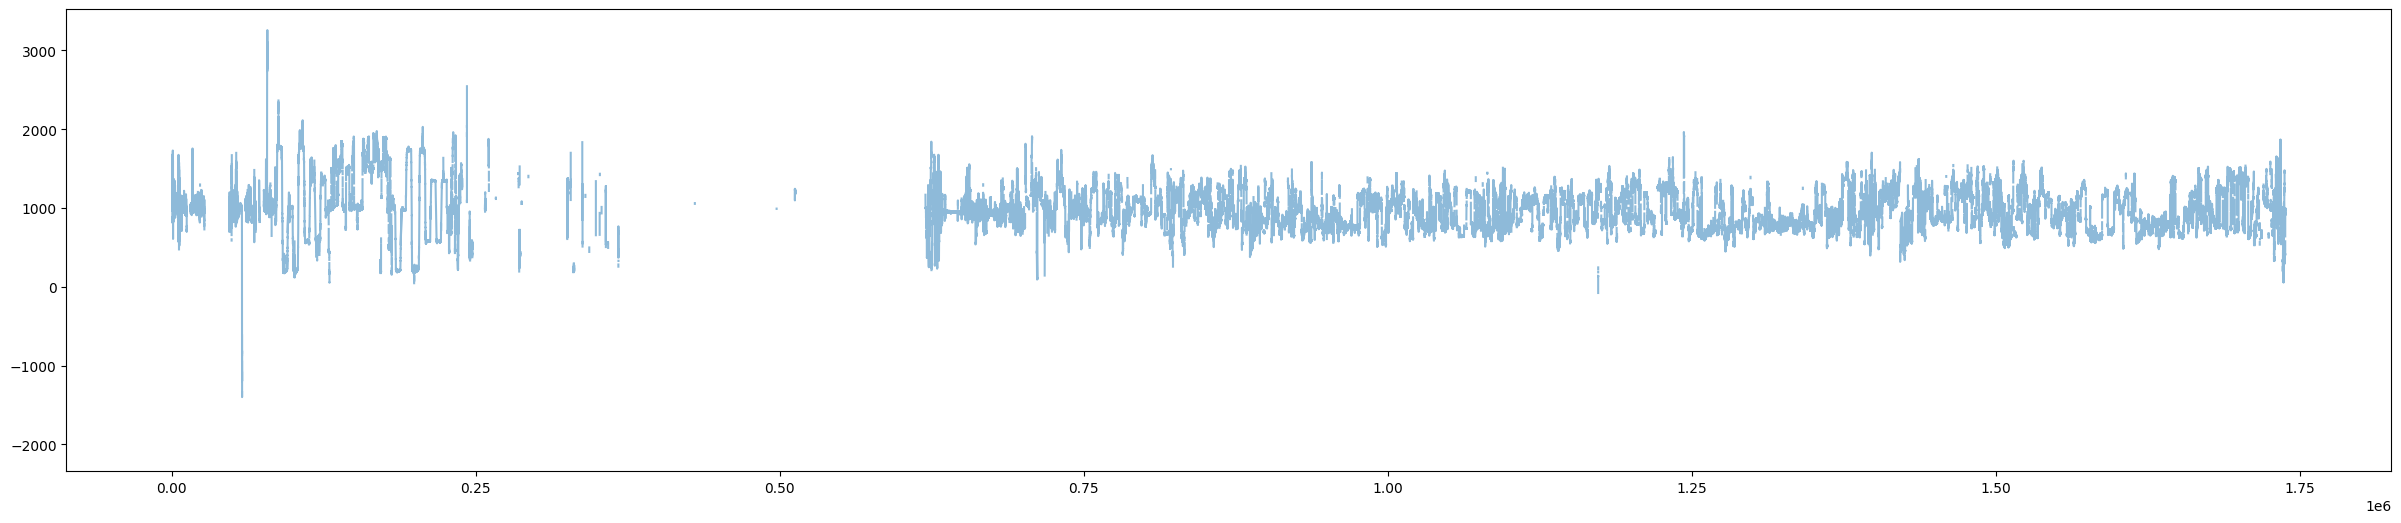

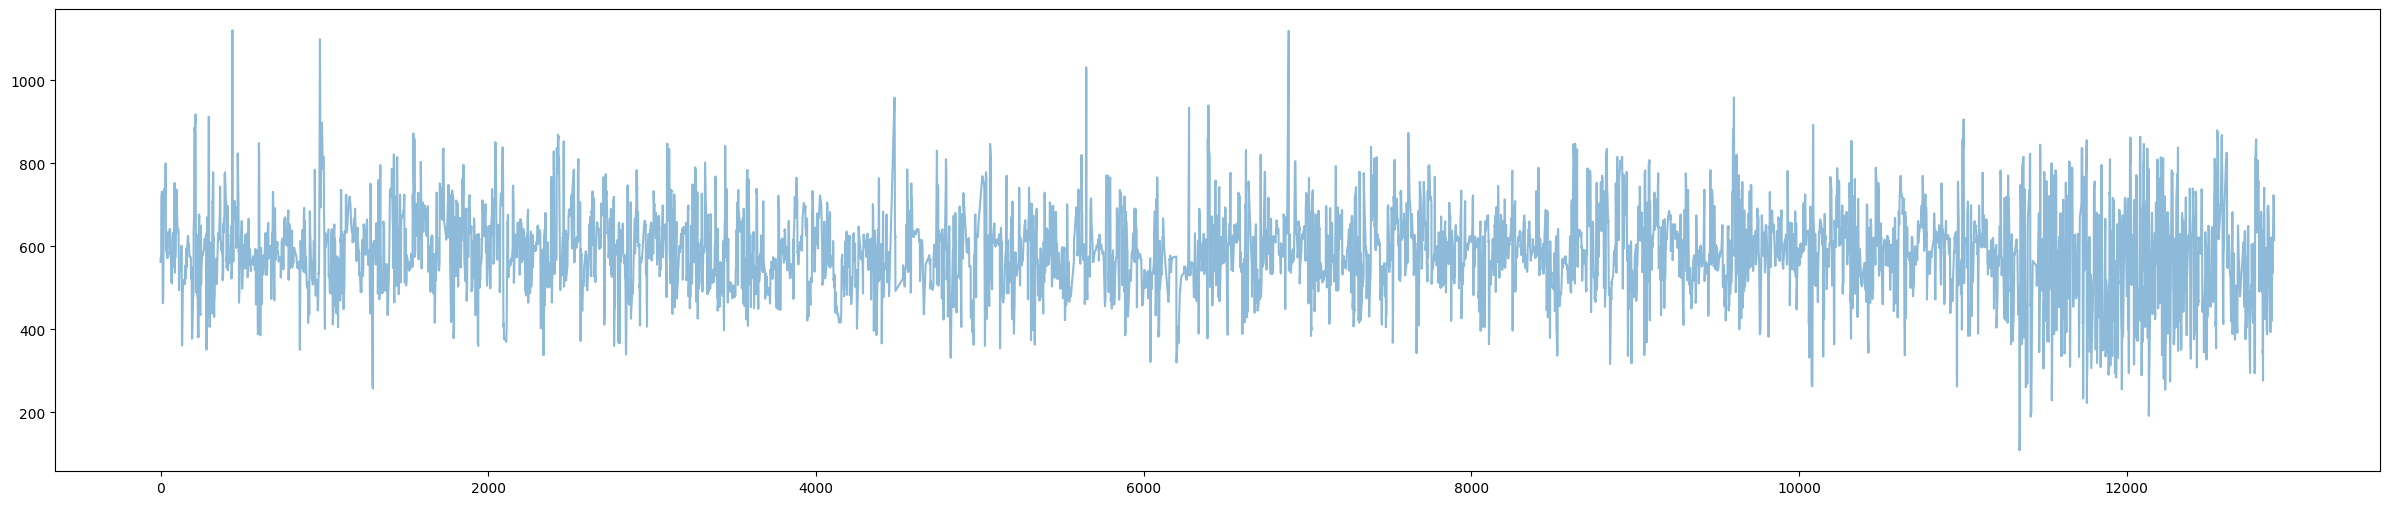

In [ ]:
participant_1_data = test_df[test_df['Participant name'] == '1']

def plot_series(series):
    figure = plt.figure(figsize=(30,6))
    plt.plot(np.arange(len(series)), series, alpha = 0.5)

p1_data_down = downsample(1000, 10, participant_1_data["x"])
plot_series(participant_1_data["x"])
plot_series(p1_data_down["x"])
#plot_series(df_10Hz["y"], eb_10Hz)
#plot_series(s_10Hz, eb_10Hz)

In [ ]:
def check_sequence(sequence):
    sampled_sequence = sequence

    # Check for NaNs
    nan_mask = np.isnan(sampled_sequence)
    num_nans = np.sum(nan_mask)

    if num_nans > 10 or nan_mask[0] == True or nan_mask[-1] == True:
        return None

    if num_nans > 0:
        # Impute NaNs using linear interpolation
        for channel in range(sampled_sequence.shape[0]):
            channel_data = sampled_sequence[channel]
            nan_indices = np.where(nan_mask[channel])[0]

            if len(nan_indices) > 0:
                # Get indices of valid (non-NaN) points
                valid_indices = np.where(~nan_mask[channel])[0]
                valid_values = channel_data[valid_indices]

                # Perform linear interpolation
                interpolated_values = np.interp(
                    nan_indices,  # Indices of NaNs to be interpolated
                    valid_indices,  # Indices of existing values
                    valid_values  # Existing values
                )

                # Replace NaNs with interpolated values
                channel_data[nan_indices] = interpolated_values

    return sampled_sequence

In [ ]:
# Filter data for Participant 1

def largest_gap_index(df):
  last_nan_indexes = []

  for participant in df['Participant name'].unique():
    participant_data = df[df['Participant name'] == participant]
    nan_indices = participant_data[participant_data['x'].isna()].index
    nan_blocks = (nan_indices.to_series().diff() > 1).cumsum()
    largest_nan_block = nan_blocks.value_counts().idxmax()
    last_nan_index = nan_indices[nan_blocks == largest_nan_block].max()
    last_nan_indexes.append(last_nan_index)

  return last_nan_indexes

last_nan_indexes_list = largest_gap_index(test_df)
print(last_nan_indexes_list)

[619703, 2191924, 3806458, 5301065, 6854776, 8633032, 10163262, 11930063]


In [ ]:
valid_data = []
last_nan_indexes_list = [619703, 2191924, 3806458, 5301065, 6854776, 8633032, 10163262, 11930063]

for i, (participant, group) in enumerate(test_df.groupby('Participant name')):
    # Get the index range for the participant
    index_range = (group.index.min(), group.index.max())

    # Find the index of the first non-NaN value in 'x'
    x_first_non_nan_index = group['x'].first_valid_index()

    a = group.index.max() + 1

    # Append to the result
    valid_data.append({
        'Participant': participant,
        'Index Range': (last_nan_indexes_list[i], group.index.max()),
        'First index': last_nan_indexes_list[i],
        'Last index': group.index.max(),
        'Length': a - last_nan_indexes_list[i]})

# Convert result to a DataFrame for better readability
valid_df = pd.DataFrame(valid_data)

# Display the result
print(valid_df)

  Participant           Index Range  First index  Last index   Length
0           1     (619703, 1738400)       619703     1738400  1118698
1           2    (2191924, 3298476)      2191924     3298476  1106553
2           3    (3806458, 4900127)      3806458     4900127  1093670
3           4    (5301065, 6647520)      5301065     6647520  1346456
4           5    (6854776, 8187233)      6854776     8187233  1332458
5           6    (8633032, 9794814)      8633032     9794814  1161783
6           7  (10163262, 11326272)     10163262    11326272  1163011
7           8  (11930063, 13033557)     11930063    13033557  1103495


In [ ]:
# Initialize an empty DataFrame to store the results
filtered_test_df = pd.DataFrame()

# Iterate through valid_df to filter data for each participant
for _, row in valid_df.iterrows():
    participant = row['Participant']
    first_index = row['First index']
    last_index = row['Last index']

    # Filter the original DataFrame for the participant and index range
    participant_data = test_df[
        (test_df['Participant name'] == participant) &
        (test_df.index >= first_index) &
        (test_df.index <= last_index)
    ]

    # Append the filtered data to the result DataFrame
    filtered_test_df = pd.concat([filtered_test_df, participant_data])

# Reset the index of the resulting DataFrame
filtered_test_df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
print(filtered_test_df)

        Participant name  Recording timestamp [ms]       x       y      p
0                      1                    516552     NaN     NaN    NaN
1                      1                    516553  1168.0  1688.0  3,441
2                      1                    516554  1151.0  1718.0  3,426
3                      1                    516555  1151.0  1745.0  3,426
4                      1                    516556  1128.0  1718.0  3,413
...                  ...                       ...     ...     ...    ...
9426119                8                   1422866  1099.0   559.0  4,503
9426120                8                   1422867  1100.0   561.0  4,503
9426121                8                   1422868  1100.0   560.0  4,503
9426122                8                   1422868  1099.0   557.0  4,503
9426123                8                   1422869  1100.0   559.0  4,502

[9426124 rows x 5 columns]


In [ ]:
data_points_count = filtered_test_df.groupby('Participant name').size()
data_points_count

,0
Participant name,
1,1118698
2,1106553
3,1093670
4,1346456
5,1332458
6,1161783
7,1163011
8,1103495


In [ ]:
b = 1118698/1000/60
b

18.64496666666667

In [ ]:
valid_df

,Participant,Index Range,First index,Last index,Length
0,1,"(619703, 1738400)",619703,1738400,1118698
1,2,"(2191924, 3298476)",2191924,3298476,1106553
2,3,"(3806458, 4900127)",3806458,4900127,1093670
3,4,"(5301065, 6647520)",5301065,6647520,1346456
4,5,"(6854776, 8187233)",6854776,8187233,1332458
5,6,"(8633032, 9794814)",8633032,9794814,1161783
6,7,"(10163262, 11326272)",10163262,11326272,1163011
7,8,"(11930063, 13033557)",11930063,13033557,1103495


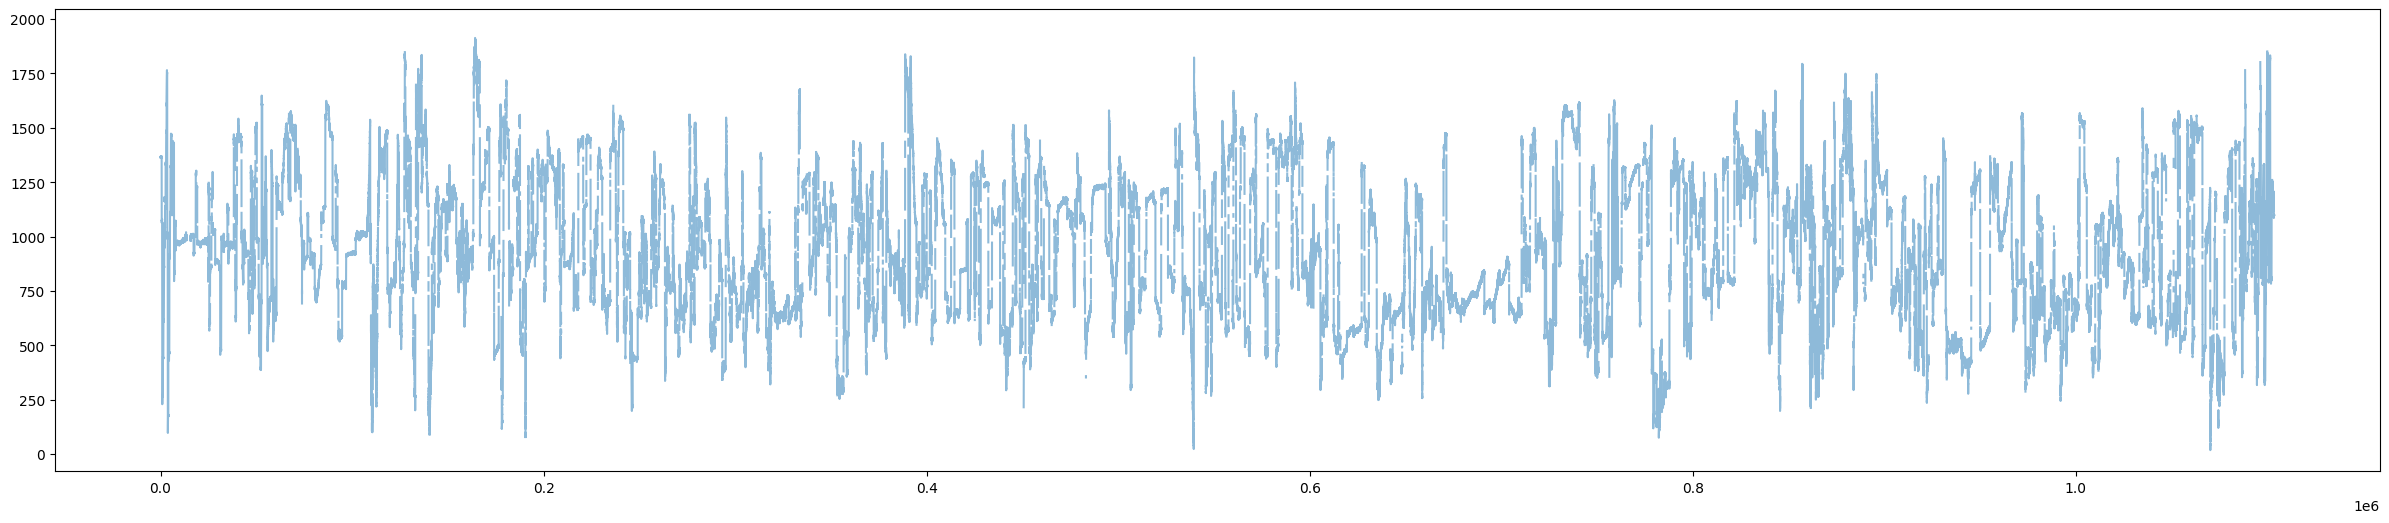

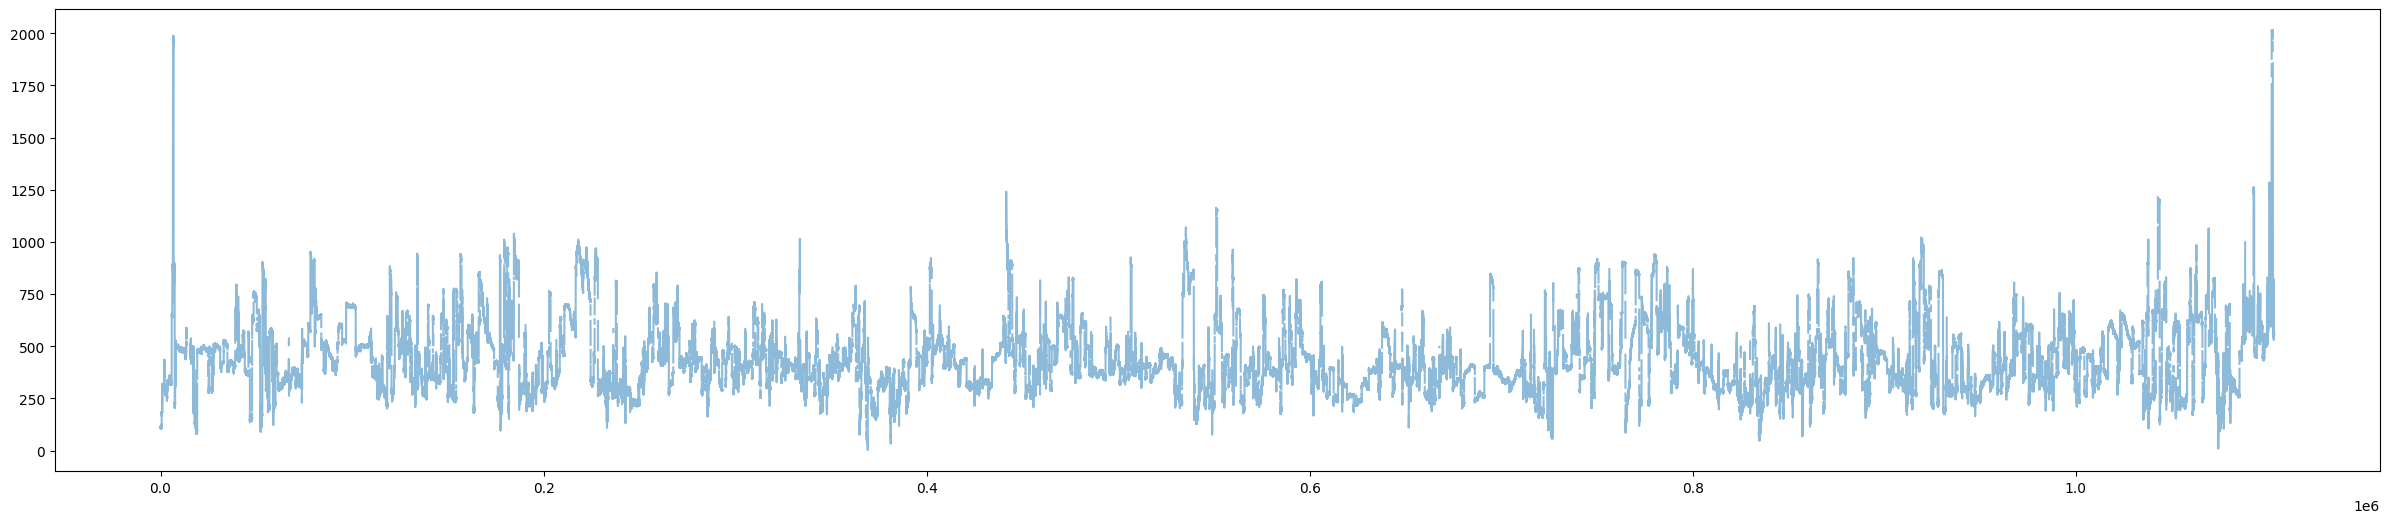

In [ ]:
participant_1_data = filtered_test_df[filtered_test_df['Participant name'] == '8']

def plot_series(series):
    figure = plt.figure(figsize=(30,6))
    plt.plot(np.arange(len(series)), series, alpha = 0.5)

plot_series(participant_1_data["x"])
plot_series(participant_1_data["y"])
#plot_series(df_10Hz["y"], eb_10Hz)
#plot_series(s_10Hz, eb_10Hz)

In [ ]:
filtered_test_df

,Participant name,Recording timestamp [ms],x,y,p
0,1,516552,NaN,NaN,NaN
1,1,516553,1168.0,1688.0,"3,441"
2,1,516554,1151.0,1718.0,"3,426"
3,1,516555,1151.0,1745.0,"3,426"
4,1,516556,1128.0,1718.0,"3,413"
...,...,...,...,...,...
9426119,8,1422866,1099.0,559.0,"4,503"
9426120,8,1422867,1100.0,561.0,"4,503"
9426121,8,1422868,1100.0,560.0,"4,503"
9426122,8,1422868,1099.0,557.0,"4,503"


In [ ]:
def calculate_speed(x_series, y_series):
    '''Todo: check correctness!!!'''
    x_series = np.array(x_series)
    y_series = np.array(y_series)

    previous_x = np.roll(x_series, 1)
    previous_y = np.roll(y_series, 1)

    delta_x = x_series - previous_x
    delta_y = y_series - previous_y

    delta_x[0] = 0
    delta_y[0] = 0

    speed = np.sqrt(delta_x**2 + delta_y**2)

    return speed

s = calculate_speed(test_df['x'], test_df['y'])

# Internal data preprocessing

In [ ]:
internal_data_path = '/content/drive/MyDrive/internal_data.csv'
internal_data = pd.read_csv(internal_data_path, sep=',')

In [ ]:
internal_data

,Participant name,Recording timestamp [ms],x,y,p
0,1,542969,1049.0,1614.0,"3,441"
1,1,543053,NaN,NaN,NaN
2,1,543136,1108.0,2071.0,"3,467"
3,1,543219,949.0,628.0,"3,647"
4,1,543303,951.0,626.0,"3,667"
...,...,...,...,...,...
62995,8,1264098,929.0,321.0,"5,232"
62996,8,1264181,913.0,324.0,"5,145"
62997,8,1264264,460.0,684.0,"5,014"
62998,8,1264348,454.0,710.0,"4,898"


In [ ]:
participants_to_use = [1, 3, 4, 5, 6, 7, 8]
for participant in participants_to_use:
  participant_data = internal_data[internal_data["Participant name"] == participant]
  participant_data["s"] = calculate_speed(participant_data["x"], participant_data["y"])
  internal_data.loc[internal_data["Participant name"] == participant, "s"] = participant_data["s"]

<ipython-input-495-d0262e0f56ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant_data["s"] = calculate_speed(participant_data["x"], participant_data["y"])
<ipython-input-495-d0262e0f56ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant_data["s"] = calculate_speed(participant_data["x"], participant_data["y"])
<ipython-input-495-d0262e0f56ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [ ]:
def check_sequence(sequence):
    """
    Checks if the sequence has no more than 10 NaNs and imputes them
    with smooth transitions (linear interpolation).
    Returns None if more than 10 NaNs are found; otherwise, returns the imputed sequence.
    """
    sequence = np.asarray(sequence, dtype=np.float64)  # Ensure numeric type

    # Check for NaNs
    nan_mask = np.isnan(sequence)
    num_nans = np.sum(nan_mask)

    if num_nans > 10:
        return None  # Too many NaNs to process

    if num_nans > 0:
        # Interpolate NaNs
        nan_indices = np.where(nan_mask)[0]
        valid_indices = np.where(~nan_mask)[0]
        valid_values = sequence[valid_indices]
        sequence[nan_indices] = np.interp(nan_indices, valid_indices, valid_values)

    return sequence

In [ ]:
def sample_events_no_events_internal(
    data,
    event_boundaries,
    num_samples=100
):

    data_length = data.shape[0]
    if data_length < 100:
        raise ValueError("Data must have at least 100 rows to extract 100-point windows.")

    # Lists to store results
    no_events = []
    events_ = []

    # Convert event_boundaries to a set for faster membership checks, if large
    event_boundaries_set = set(event_boundaries)

    # We'll sample until we have enough in both lists
    # or we reach some iteration limit (to avoid infinite loops).
    max_iterations = 10000000  # Arbitrary large limit
    iteration_count = 0

    while (len(no_events) < num_samples or len(events_) < num_samples):
        iteration_count += 1

        # 1) Pick a random start index
        start_idx = random.randint(0, data_length - 100)
        end_idx = start_idx + 100

        # 2) Count how many boundaries in [start_idx, end_idx)
        #    We'll just iterate over the set:
        boundaries_in_window = 0
        for b in event_boundaries_set:
            if start_idx <= b < end_idx:
                boundaries_in_window += 1
            if boundaries_in_window > 1:
                break  # no need to count further if it's >1

        # 3) If exactly 0 or exactly 1, store them
        if boundaries_in_window == 0 and len(no_events) < num_samples:
            # Slice out the speed and pupil
            speed_100 = data[start_idx:end_idx, 0]
            pupil_100 = data[start_idx:end_idx, 1]
            if not check_sequence(speed_100) is None and not check_sequence(pupil_100) is None:
              no_events.append((speed_100, pupil_100))
        elif boundaries_in_window == 1 and len(events_) < num_samples:
            speed_100 = data[start_idx:end_idx, 0]
            pupil_100 = data[start_idx:end_idx, 1]
            if not check_sequence(speed_100) is None and not check_sequence(pupil_100) is None:
              events_.append((speed_100, pupil_100))
        # else ignore if boundaries_in_window >= 2

    return no_events, events_

In [ ]:
internal_eb_list = [34, 97, 144, 178, 308, 380, 435, 597, 627, 638, 690, 798, 855]
internal_eb_10Hz = list(i*10 for i in internal_eb_list)

In [ ]:
def remove_comma(number_str):
  number_float = float(str(number_str).replace(",", ""))
  return number_float

internal_data["p"] = internal_data["p"].apply(remove_comma)
internal_data

,Participant name,Recording timestamp [ms],x,y,p,s
0,1,542969,1049.0,1614.0,3441.0,0.000000
1,1,543053,NaN,NaN,NaN,NaN
2,1,543136,1108.0,2071.0,3467.0,NaN
3,1,543219,949.0,628.0,3647.0,1451.733447
4,1,543303,951.0,626.0,3667.0,2.828427
...,...,...,...,...,...,...
62995,8,1264098,929.0,321.0,5232.0,8.062258
62996,8,1264181,913.0,324.0,5145.0,16.278821
62997,8,1264264,460.0,684.0,5014.0,578.626823
62998,8,1264348,454.0,710.0,4898.0,26.683328


## Sampling


In [ ]:
df_output_internal = pd.DataFrame(columns=['participant', 'data'])
for participant in [1]:
  data_internal = internal_data[internal_data["Participant name"] == participant][["s", "p"]]
  data_internal = data_internal.to_numpy(dtype=np.float64)
  no_events, events = sample_events_no_events_internal(data_internal, internal_eb_10Hz)
  dataset = merge_datasets(no_events, events)
  new_row = {'participant': participant, 'data': dataset}
  df_output_internal.loc[len(df_output_internal)] = new_row

In [ ]:
#df_output_internal_final.loc[len(df_output_internal_final)] = [new_row["participant"], new_row["data"]]

In [ ]:
df_output_internal_final

,participant,data
0,1,"[([39.22043948207923, 75.61245183941226, 112.0..."
1,4,"[([7.615773105863909, 2.23606797749979, 182.61..."


In [ ]:
new_list_internal = []
for element in df_output_internal["data"]:
    for subelement in element:
        new_list_internal.append(subelement)

In [ ]:
test_features = list(element[:2] for element in new_list_internal)
test_labels = list(element[2] for element in new_list_internal)

In [ ]:
np_test_features = np.array(test_features)
np_test_labels = np.array(test_labels)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = test_features
        self.labels = test_labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype = torch.float32), torch.tensor(self.labels[idx], dtype = torch.float32)

In [ ]:
test_features_internal = torch.tensor(np_features, dtype=torch.float32)
test_labels_internal = torch.tensor(np_labels, dtype=torch.float32)

print(test_labels_internal.shape)

torch.Size([21000])


In [ ]:
test_features_internal = torch.tensor(np_test_features, dtype=torch.float32)
test_labels_internal = torch.tensor(np_test_labels, dtype=torch.float32)

print(test_labels_internal.shape)

torch.Size([200])


In [ ]:
# Compute mean and std across all sequences and time points for each channel
test_mean = test_features_internal.mean(dim=(0, 2), keepdim=True)  # Shape: (1, 2, 1)
test_std = test_features_internal.std(dim=(0, 2), keepdim=True)    # Shape: (1, 2, 1)

# Standardize the training data
test_data_standardized = (test_features_internal - test_mean) / test_std

In [ ]:
# Create the dataset
test_dataset = CustomDataset(test_data_standardized, test_labels_internal)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
test_data_standardized.shape

torch.Size([200, 2, 100])

In [ ]:
test_accuracy = calculate_accuracy(model, test_dataloader, device)
print(test_accuracy)

47.0


In [ ]:
print(internal_data[internal_data["Participant name"] == 6][["s", "p"]])

               s       p
36000   0.000000  3473.0
36001  13.601471  3490.0
36002  17.464249  3474.0
36003  19.416488  3452.0
36004   4.472136  3447.0
...          ...     ...
44995   7.810250  4871.0
44996  23.409400  4876.0
44997   7.071068  4883.0
44998  10.198039  4888.0
44999  12.369317  4908.0

[9000 rows x 2 columns]


In [ ]:
max_accuracy = 0
best_participants_data = []

for i in range (1000):
  df_output_internal = pd.DataFrame(columns=['participant', 'data'])
  for participant in [1]:
    data_internal = internal_data[internal_data["Participant name"] == participant][["s", "p"]]
    data_internal = data_internal.to_numpy(dtype=np.float64)
    no_events, events = sample_events_no_events_internal(data_internal, internal_eb_10Hz)
    dataset = merge_datasets(no_events, events)
    #print(dataset[:20])
    new_row = {'participant': participant, 'data': dataset}
    df_output_internal.loc[len(df_output_internal)] = new_row

  new_list_internal = []
  for element in df_output_internal["data"]:
      for subelement in element:
          new_list_internal.append(subelement)

  test_features = list(element[:2] for element in new_list_internal)
  test_labels = list(element[2] for element in new_list_internal)

  np_test_features = np.array(test_features)
  np_test_labels = np.array(test_labels)

  test_features_internal = torch.tensor(np_test_features, dtype=torch.float32)
  test_labels_internal = torch.tensor(np_test_labels, dtype=torch.float32)

  # Compute mean and std across all sequences and time points for each channel
  test_mean = test_features_internal.mean(dim=(0, 2), keepdim=True)  # Shape: (1, 2, 1)
  test_std = test_features_internal.std(dim=(0, 2), keepdim=True)    # Shape: (1, 2, 1)

  # Standardize the training data
  test_data_standardized = (test_features_internal - test_mean) / test_std

  # Create the dataset
  test_dataset = CustomDataset(test_data_standardized, test_labels_internal)

  test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

  test_accuracy = calculate_accuracy(model, test_dataloader, device)

  if test_accuracy > max_accuracy:
    max_accuracy = test_accuracy
    best_participants_data = new_row['data']
print(max_accuracy)

61.5


In [ ]:
#df_output_internal_final = pd.DataFrame(columns=['participant', 'data'])

In [ ]:
df_output_internal_final.loc[len(df_output_internal_final)]

,6
participant,8
data,"[([345.60092592468555, 101.65136496870073, 2.0..."


In [ ]:
df_output_internal_final.loc[len(df_output_internal_final)+1] = [new_row["participant"], best_participants_data]

In [ ]:
df_output_internal_finall = df_output_internal_final[1:]

In [ ]:
df_output_internal_final
# 1 - 61.5
# 3 - 54.0
# 4 - 57.5
# 5 - 61.5
# 6 - 60.5
# 7 - 63.0
# 8 - 67

,participant,data
1,3,"[([2.0, 2.0, 2.0, 2.0, 9.219544457292887, 4.0,..."
2,4,"[([0.0, 149.56603892595405, 2.23606797749979, ..."
3,5,"[([30.74719034732065, 26.82450904792187, 22.90..."
4,6,"[([7.211102550927978, 10.44030650891055, 34.23..."
5,7,"[([936.6973897689691, 16.278820596099706, 8.54..."
6,8,"[([345.60092592468555, 101.65136496870073, 2.0..."
7,1,"[([1.0, 2.23606797749979, 4.242640687119285, 2..."


In [ ]:
def numpy_encoder(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert NumPy array to list
    raise TypeError("Type not serializable")

for row in range (1, 8):
  output_file = "/content/drive/MyDrive/data" + str(df_output_internal_final.loc[row]["participant"]) + ".json"
  data = df_output_internal_final.loc[row]["data"]
  with open(output_file, "w") as json_file:
    json.dump(data, json_file, indent=4, default=numpy_encoder)  # `indent` makes the JSON file more readable



## Testing HMM on own data


In [ ]:
len(np_test_features[0][0])

100

In [ ]:
np_test_features

array([[[5.14635794e+02, 3.58615393e+02, 2.82842712e+00, ...,
         3.04236750e+02, 3.00000000e+00, 1.41421356e+00],
        [3.71000000e+03, 3.63300000e+03, 3.57900000e+03, ...,
         3.47200000e+03, 3.51900000e+03, 3.56900000e+03]],

       [[1.00000000e+00, 2.00000000e+00, 2.71532687e+02, ...,
         6.55133574e+01, 5.88557559e+01, 5.77061522e+01],
        [3.68800000e+03, 3.68600000e+03, 3.68800000e+03, ...,
         3.89400000e+03, 3.93800000e+03, 4.00300000e+03]],

       [[1.00000000e+00, 3.25775997e+02, 7.13091859e+01, ...,
         1.00000000e+00, 9.62548700e+01, 1.00000000e+00],
        [3.51800000e+03, 3.40900000e+03, 3.30400000e+03, ...,
         3.50000000e+03, 3.50100000e+03, 3.51900000e+03]],

       ...,

       [[9.00000000e+00, 4.55389943e+02, 4.47213595e+00, ...,
         1.00000000e+00, 1.41421356e+00, 1.00000000e+00],
        [3.88700000e+03, 3.94700000e+03, 4.00000000e+03, ...,
         4.40500000e+03, 4.42200000e+03, 4.44100000e+03]],

       [[5.22015325

In [ ]:
X_reshaped = np_test_features.reshape(200, -1)  # Flatten the (2, 100) part to (200) for each sequence
_, X_test, _, y_test = train_test_split(X_reshaped, np_labels, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [200, 21000]

In [ ]:
log_likelihood_class_0 = np.array([model_class_0.score(X_test[i].reshape(1, -1)) for i in range(X_test.shape[0])])
log_likelihood_class_1 = np.array([model_class_1.score(X_test[i].reshape(1, -1)) for i in range(X_test.shape[0])])

# Assign class 0 if the log-likelihood of class 0 is higher, else assign class 1
y_pred = (log_likelihood_class_1 > log_likelihood_class_0).astype(int)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Data standardization

In [ ]:
test_data_standardized[6][0]

In [ ]:
train_data_standardized[6][0]